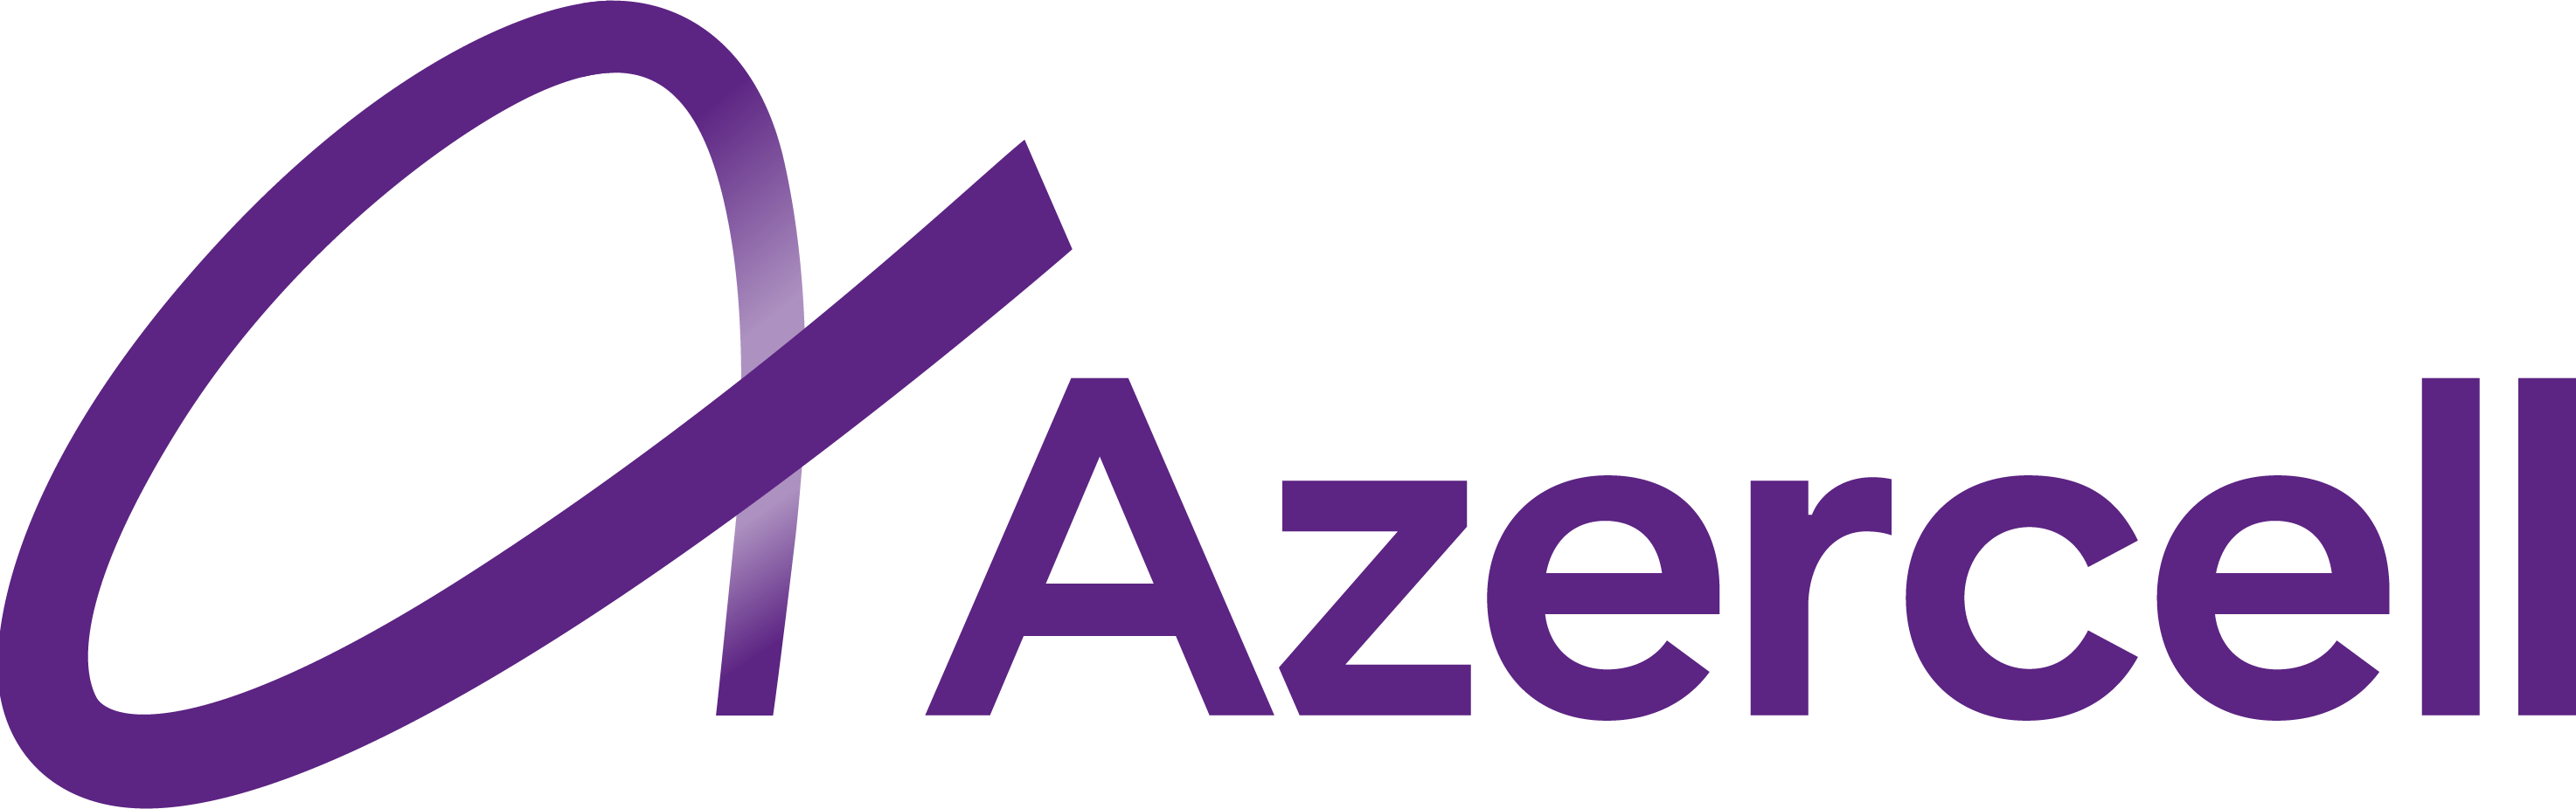

In [2]:
# Libraries
import pandas as pd
import warnings as wg
wg.filterwarnings('ignore')
from deep_translator import GoogleTranslator
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from googletrans import Translator
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [1]:
# Install Packages
!pip install deep_translator
!pip install googletrans
!pip install faiss-cpu
!pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [ ]:
# Datasets
comments_image = pd.read_excel('/content/azercell_facebook_image_comments.xlsx')
comments_video = pd.read_excel('/content/azercell_facebook_video_comments.xlsx')

## Məlumatların təmizlənməsi və birləşdirilməsi

In [ ]:
comments_video.index = range(len(comments_image), len(comments_image) + len(comments_video))

comments = pd.concat([comments_image, comments_video])
comments.columns = ['hesab_adı','rəy','rəy_tarix','post_şəkil']

## Tərcümə

In [ ]:
comments_customer = comments[comments['hesab_adı'] != 'Azercell']

translator = GoogleTranslator(source='az', target='en')
comments_customer['rəy_eng'] = comments_customer['rəy'].apply(lambda x: translator.translate(x))

## Semantik Analiz: zero-shot-classification

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
candidate_labels = ["Question", "Complaint", "Praise", "Other"]

def comment_group(x):
    try:
        comment = x
        results = classifier(comment, candidate_labels)
        labels = results['labels']
        scores = results['scores']
        label_score_dict = dict(zip(labels, scores))
        praise = label_score_dict['Praise']
        other = label_score_dict['Other']
        question = label_score_dict['Question']
        complaint = label_score_dict['Complaint']
        return praise,other,question,complaint
    except Exception as e:
        return 0, 0, 0, 0

comments_customer[['Tərif', 'Başqa', 'Sual', 'Şikayət']] = comments_customer['rəy_eng'].apply(lambda x: pd.Series(comment_group(x)))

In [ ]:
columns_to_consider = ['Tərif', 'Başqa', 'Sual', 'Şikayət']

def get_max_column(row):
    return row[columns_to_consider].idxmax()

comments_customer['rəyin_kateqoriyası_z_s_c'] = comments_customer.apply(get_max_column, axis=1)

## Chatbot üçün Məlumatın Hazırlanması

In [ ]:
comments['azercell'] = comments['hesab_adı'].apply(lambda x: 1 if x == 'Azercell' else 0)

indices = comments[comments.iloc[:, -1] == 1].index
selected_rows = comments.loc[sorted(set(indices) | set(indices - 1))]

selected_rows.reset_index(inplace = True, drop = True)

azercell = selected_rows[selected_rows['azercell'] == 1]
customer = selected_rows[selected_rows['azercell'] == 0]

azercell.reset_index(inplace = True)
azercell['Index'] = azercell['index']
del azercell['index']

In [ ]:
merged_comments = []
current_comment = None
start_index = None

for i in range(len(azercell)):
    current_row = azercell.loc[i]

    # Əgər current_comment boşdursa, yeni bir başlama nöqtəsi təyin edirik
    if current_comment is None:
        current_comment = current_row["rəy"]
        start_index = current_row["Index"]
        start_comment_time = current_row["rəy_tarix"]
    else:
        prev_index = azercell.loc[i - 1, "Index"]

        # Əgər bir əvvəlki Index ilə ardıcıl deyilsə (məsələn 1 fərq varsa)
        if current_row["Index"] != prev_index + 1:
            merged_comments.append((
                start_index,
                current_comment,
                start_comment_time
            ))
            current_comment = current_row["rəy"]
            start_index = current_row["Index"]
            start_comment_time = current_row["rəy_tarix"]
        else:
            current_comment += " " + current_row["rəy"]

merged_comments.append((
    start_index,
    current_comment,
    start_comment_time,
))

merged_df = pd.DataFrame(merged_comments, columns=[
    "Index", "rəy", "rəy_tarix"
])

In [7]:
merged_df['Index'] = merged_df['Index'].apply(lambda x: x-1)
merged_df.set_index('Index',inplace = True)
merged_df.columns = ['azercell_cavab','cavab_vaxt']


result_df = customer.join(merged_df, how='inner')

result_df = pd.read_excel('ques_answer.xlsx')

del result_df['azercell']
chatbot_df = result_df[['hesab_adı', 'rəy','azercell_cavab']]

In [8]:
df = chatbot_df.copy()

def preprocess_text(text):
    return text.lower()

def ans_processed(row):
    name = row['hesab_adı'].lower()
    return row['azercell_cavab'].lower().replace(name, '').strip()


df['rəy_processed'] = df['rəy'].apply(preprocess_text)
df['azercell_cavab'] = df['azercell_cavab'].apply(preprocess_text)
df['ans_processed'] = df.apply(ans_processed, axis=1)

def extract_section(text):
    match = re.search(r'salam,\s(.*?\.)', text)
    if match:
        return match.group(1)
    else:
        return ''

df['extracted_section'] = df['azercell_cavab'].apply(extract_section)

def ans_processed(row):
    name = row['extracted_section'].lower()
    return row['ans_processed'].lower().replace(name, '').strip()

df['ans_processed'] = df.apply(ans_processed, axis=1)

del df['extracted_section']

## Chatbot-un Hazırlanması

## Method 1: Fais indexindən istifadə edərək ən yaxın cavabın tapılması

In [10]:
# BERT modeli
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Bütün sualları vektorlaşdırırıq (embedding yaradırıq)
question_embeddings = model.encode(df["rəy_processed"].tolist(), convert_to_numpy=True)

# FAISS indeksini yaradırıq
index = faiss.IndexFlatL2(question_embeddings.shape[1])  # L2 məsafə metodu ilə indeks yaradılır
index.add(question_embeddings)  # Vektorları FAISS indeksinə əlavə edirik

def chatbot_bert(user_question):
    # İstifadəçinin sualını BERT ilə vektorlaşdırırıq
    user_embedding = model.encode([user_question], convert_to_numpy=True)

    # FAISS ilə ən yaxın oxşar sualı tapırıq
    D, I = index.search(user_embedding, 1)  # 1 ən yaxın nəticəni qaytar

    # Ən uyğun cavabı qaytarırıq
    matched_index = I[0][0]  # Ən yaxın oxşar sualın indeksini alırıq
    return df.iloc[matched_index]["ans_processed"]

In [11]:
question = "salam internet işlemir"
answer = chatbot_bert(question)
print("Chatbot cavabı:", answer)

Chatbot cavabı: salam, .
simsim abunəçiləri üçün gənc ol çərçivəsində 2 tarif təqdim olunur: gənc ol 5 və gənc ol 8.… see more


## Method 2: TfidfVectorizer və cosine similarity vasitəsi ilə uyğun cavabın verilməsi

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['rəy_processed'])

def chatbot_answer(user_query):
    user_query_processed = preprocess_text(user_query)
    user_query_vec = vectorizer.transform([user_query_processed])

    similarity_scores = cosine_similarity(user_query_vec, X)

    best_match_idx = similarity_scores.argmax()

    return df['ans_processed'].iloc[best_match_idx]

user_question = "aylig internet paketi var?	"
answer = chatbot_answer(user_question)
print(answer)

salam, 
aylıq internet paketlər haqda ətraflı məlumat: http://www.azercell.com/.../per.../internet/datapacks/packs/
